In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Read data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True, sort=False)
train.shape, test.shape, data.shape

((8523, 13), (5681, 12), (14204, 13))

In [3]:
# Check missing values
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [4]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [6]:
# Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
# Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
# Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

In [7]:
# Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

# Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

# Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))

data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [8]:
#Import mode function:
from scipy.stats import mode

outlet_size_mode = data.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode()[0])
print ('Mode for each Outlet_Type: \n' )
print (outlet_size_mode)

Mode for each Outlet_Type: 

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object


In [9]:
# Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

# Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))


Orignal #missing: 4016
0


In [10]:
# Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

# Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [11]:
# Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)
print (data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [12]:
# Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
# Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [13]:
# Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [14]:
# Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [15]:
# Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [16]:
# Import sklearn:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [17]:
# One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [18]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Item_Outlet_Sales', 'source', 'Item_Visibility_MeanRatio',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Item_Fat_Content_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9'],
      dtype='object')

In [19]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [20]:
# Normalize numerical variable

# all_num = data.select_dtypes(include=['float64'])

# skewness = all_num.apply(lambda x: x.skew())
# skewness.sort_values(ascending=False)
# skewness = skewness[abs(skewness)>0.5]
# data[skewness.index] = np.log1p(all_num[skewness.index])
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Item_Outlet_Sales', 'source', 'Item_Visibility_MeanRatio',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Item_Fat_Content_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9'],
      dtype='object')

In [21]:
# Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

# Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

# Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

# Export files as modified versions:
train.to_csv("data/train_modified.csv",index=False)
test.to_csv("data/test_modified.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
train

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.300,0.016047,249.8092,OUT049,3735.1380,0.931078,14,1,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.920,0.019278,48.2692,OUT018,443.4228,0.933420,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.500,0.016760,141.6180,OUT049,2097.2700,0.960069,14,1,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.200,0.017834,182.0950,OUT010,732.3800,1.000000,15,0,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.930,0.009780,53.8614,OUT013,994.7052,1.000000,26,0,1,...,0,1,0,0,0,0,0,0,0,0
5,FDP36,10.395,0.057059,51.4008,OUT018,556.6088,1.000000,4,0,0,...,0,0,0,1,0,0,0,0,0,0
6,FDO10,13.650,0.012741,57.6588,OUT013,343.5528,1.497197,26,0,0,...,0,1,0,0,0,0,0,0,0,0
7,FDP10,19.000,0.127470,107.7622,OUT027,4022.7636,0.870493,28,1,0,...,0,0,0,0,0,1,0,0,0,0
8,FDH17,16.200,0.016687,96.9726,OUT045,1076.5986,0.924160,11,0,0,...,0,0,0,0,0,0,0,1,0,0
9,FDU28,19.200,0.094450,187.8214,OUT017,4710.5350,0.963983,6,0,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext()

In [24]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("test").getOrCreate()

In [25]:
from pyspark.ml.feature import VectorAssembler

IDcol = ['Item_Identifier','Outlet_Identifier']

train_all = train.drop(IDcol, axis=1)

# train_x_all = train.drop(['Item_Outlet_Sales'] + IDcol, axis=1)
# train_y_all = train['Item_Outlet_Sales']

# Change pandas dataframe to spark dataframe
train_all  = spark.createDataFrame(train_all.values.tolist(), list(train_all.columns))

# Get feature columns'name
feature_cols = train_all.columns
feature_cols.remove('Item_Outlet_Sales')

train_all.show(3)

# Combine all feature columns to one
vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
train_all = vectorAssembler.transform(train_all)
train_all = train_all.select(['features', 'Item_Outlet_Sales'])
train_all.show(3)

train_all.take(1)

+-----------+---------------+--------+-----------------+-------------------------+------------+------------------+------------------+------------------+----------------------+----------------------+----------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|Item_Weight|Item_Visibility|Item_MRP|Item_Outlet_Sales|Item_Visibility_MeanRatio|Outlet_Years|Item_Fat_Content_0|Item_Fat_Content_1|Item_Fat_Content_2|Outlet_Location_Type_0|Outlet_Location_Type_1|Outlet_Location_Type_2|Outlet_Size_0|Outlet_Size_1|Outlet_Size_2|Outlet_Type_0|Outlet_Type_1|Outlet_Type_2|Outlet_Type_3|Item_Type_Combined_0|Item_Type_Combined_1|Item_Type_Combined_2|Outlet_0|Outlet_1|Outlet_2|Outlet_3|Outlet_4|Outlet_5|Outlet_6|Outlet_7|Outlet_8|Outlet_9|
+-----------+---------------+--------+----------------

[Row(features=SparseVector(31, {0: 9.3, 1: 0.016, 2: 249.8092, 3: 0.9311, 4: 14.0, 5: 1.0, 8: 1.0, 12: 1.0, 15: 1.0, 19: 1.0, 30: 1.0}), Item_Outlet_Sales=3735.138)]

In [26]:
# Split train data and test data
splits = train_all.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

RMSE: 1134.620737
R2: 0.565567
+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|2390.7083020284613|        2478.7734|(31,[0,1,2,3,4,5,...|
|3619.6226290289483|7017.531999999999|(31,[0,1,2,3,4,5,...|
| 1033.119832645065|         703.0848|(31,[0,1,2,3,4,5,...|
|1330.1403926289945|         451.4124|(31,[0,1,2,3,4,5,...|
| 3932.902031494975|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1111.86
R Squared (R2) on test data = 0.556326


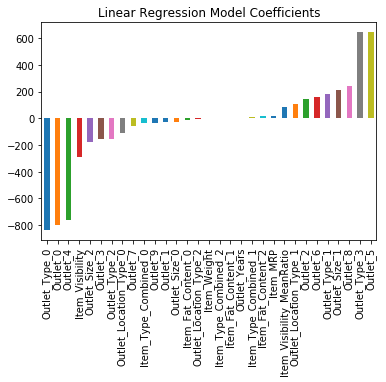

In [27]:
# Linear Regression Model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=100, regParam=0.0, elasticNetParam=0.0)
lr_model = lr.fit(train_df)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

lr_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_r2.evaluate(lr_predictions))

coef1 = pd.Series(lr_model.coefficients, feature_cols).sort_values()
coef1.plot(kind='bar', title='Linear Regression Model Coefficients')

RMSE: 1134.620755
R2: 0.565567
+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|2390.6678103879244|        2478.7734|(31,[0,1,2,3,4,5,...|
|3619.3958457055146|7017.531999999999|(31,[0,1,2,3,4,5,...|
| 1033.357760358653|         703.0848|(31,[0,1,2,3,4,5,...|
|1330.2019362765413|         451.4124|(31,[0,1,2,3,4,5,...|
|3932.6506253704565|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1111.85
R Squared (R2) on test data = 0.556331


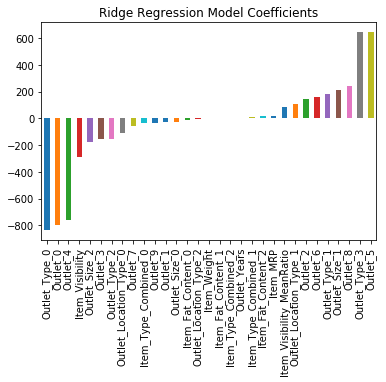

In [28]:
# Ridge Regression Model
rr = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=100, regParam=0.3, elasticNetParam=0)
rr_model = rr.fit(train_df)

trainingSummary = rr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
rr_predictions = rr_model.transform(test_df)
rr_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

rr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % rr_evaluator.evaluate(rr_predictions))

rr_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % rr_evaluator_r2.evaluate(rr_predictions))

coef2 = pd.Series(rr_model.coefficients, feature_cols).sort_values()
coef2.plot(kind='bar', title='Ridge Regression Model Coefficients')

RMSE: 1134.622556
R2: 0.565565
+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|2392.5288623254833|        2478.7734|(31,[0,1,2,3,4,5,...|
|3621.0791189595857|7017.531999999999|(31,[0,1,2,3,4,5,...|
|1034.4664403305997|         703.0848|(31,[0,1,2,3,4,5,...|
|1328.7202454519306|         451.4124|(31,[0,1,2,3,4,5,...|
|   3932.8048713305|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1111.84
R Squared (R2) on test data = 0.556337


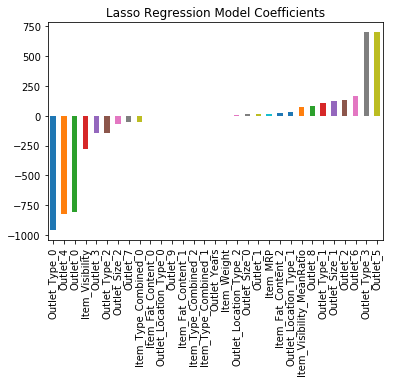

In [29]:
#  Lasso Regression Model
lar = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=100, regParam=0.3, elasticNetParam=1)
lar_model = lar.fit(train_df)

trainingSummary = lar_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
lar_predictions = lar_model.transform(test_df)
lar_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

lar_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % lar_evaluator.evaluate(lar_predictions))

lar_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % lar_evaluator_r2.evaluate(lar_predictions))

coef3 = pd.Series(lar_model.coefficients, feature_cols).sort_values()
coef3.plot(kind='bar', title='Lasso Regression Model Coefficients')

RMSE: 1134.621190
R2: 0.565566
+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
| 2392.044778005144|        2478.7734|(31,[0,1,2,3,4,5,...|
|3620.6815992215966|7017.531999999999|(31,[0,1,2,3,4,5,...|
|1034.3410226717044|         703.0848|(31,[0,1,2,3,4,5,...|
|1329.4707175642668|         451.4124|(31,[0,1,2,3,4,5,...|
|3932.7964145703795|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1111.85
R Squared (R2) on test data = 0.556332


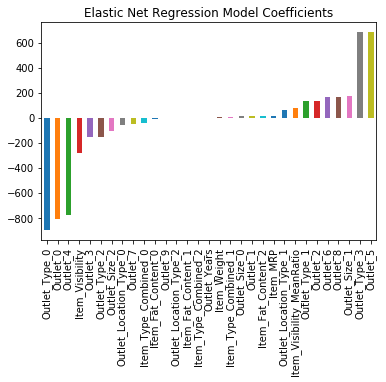

In [30]:
# Elastic Net Regression Model
enl = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=100, regParam=0.3, elasticNetParam=0.5)
enl_model = enl.fit(train_df)

trainingSummary = enl_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
enl_predictions = enl_model.transform(test_df)
enl_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

enl_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % enl_evaluator.evaluate(enl_predictions))

enl_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % enl_evaluator_r2.evaluate(enl_predictions))

coef4 = pd.Series(enl_model.coefficients, feature_cols).sort_values()
coef4.plot(kind='bar', title='Elastic Net Regression Model Coefficients')

+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|2389.8760450980394|        2478.7734|(31,[0,1,2,3,4,5,...|
|3115.4012890756308|7017.531999999999|(31,[0,1,2,3,4,5,...|
| 968.7133923076925|         703.0848|(31,[0,1,2,3,4,5,...|
| 1373.090505590062|         451.4124|(31,[0,1,2,3,4,5,...|
| 3636.631304761905|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1091.76
R Squared (R2) on test data = 0.572218


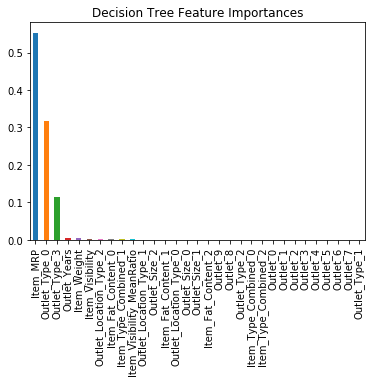

In [31]:
# Decision Tree Regression Model
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxDepth=15, minInstancesPerNode=100)
dt_model = dt.fit(train_df)

# Predict and Evaluate
dt_predictions = dt_model.transform(test_df)
dt_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

df_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % df_evaluator.evaluate(dt_predictions))

df_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % df_evaluator_r2.evaluate(dt_predictions))

coef5 = pd.Series(dt_model.featureImportances, feature_cols).sort_values(ascending=False)
coef5.plot(kind='bar', title='Decision Tree Feature Importances')

+-----------------+-----------------+--------------------+
|       prediction|Item_Outlet_Sales|            features|
+-----------------+-----------------+--------------------+
|2397.701738346828|        2478.7734|(31,[0,1,2,3,4,5,...|
|3340.112382142578|7017.531999999999|(31,[0,1,2,3,4,5,...|
| 850.618232716041|         703.0848|(31,[0,1,2,3,4,5,...|
|1270.811763042304|         451.4124|(31,[0,1,2,3,4,5,...|
|4010.716253202037|         5942.265|(31,[0,1,2,3,4,5,...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1082.36
R Squared (R2) on test data = 0.579554


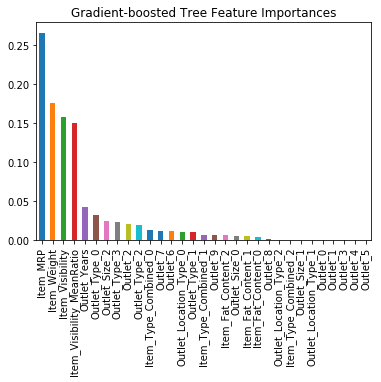

In [32]:
# Gradient-boosted Tree Regression
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=10)
# gbt = GBTRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=10, maxDepth=15, minInstancesPerNode=100)
gbt_model = gbt.fit(train_df)

# Predict and Evaluate
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

gbt_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator_r2.evaluate(gbt_predictions))

coef6 = pd.Series(gbt_model.featureImportances, feature_cols).sort_values(ascending=False)
coef6.plot(kind='bar', title='Gradient-boosted Tree Feature Importances')

In [33]:
# Random Forest Model
# Without CrossValidation

from pyspark.ml.regression import RandomForestRegressor

# rf = RandomForestRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', numTrees=400, maxDepth=6, minInstancesPerNode=100)
# rf_model = rf.fit(train_df)
# print("Feature Importances: " + str(rf_model.featureImportances))

# rf_predictions = rf_model.transform(test_df)
# rf_predictions.select("prediction","Item_Outlet_Sales","features").show(5)
# rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
# print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rf_predictions))

# coef7 = pd.Series(rf_model.featureImportances, feature_cols).sort_values(ascending=False)
# coef7.plot(kind='bar', title='Feature Importances')


+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|2433.3006841227516|        2478.7734|(31,[0,1,2,3,4,5,...|
|3421.9345345802826|7017.531999999999|(31,[0,1,2,3,4,5,...|
|1004.7560722371267|         703.0848|(31,[0,1,2,3,4,5,...|
|1254.1953640383902|         451.4124|(31,[0,1,2,3,4,5,...|
| 3893.158144055465|         5942.265|(31,[0,1,2,3,4,5,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1082.36
R Squared (R2) on test data = 0.587805


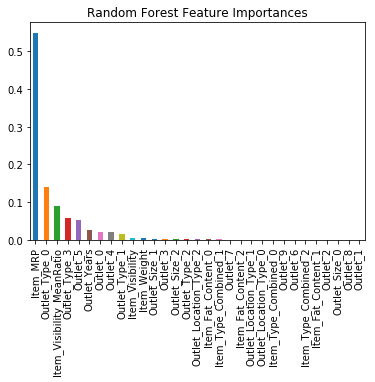

In [34]:
# CrossValidation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rf = RandomForestRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', minInstancesPerNode=100)

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 6, 10]) \
    .addGrid(rf.numTrees, [200, 400]) \
    .build()

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=rf_evaluator, numFolds=5, parallelism=5)

cv_model = cv.fit(train_df)

rf_predictions = cv_model.transform(test_df)
rf_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

print("Root Mean Square Error (RMSE) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

rf_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator_r2.evaluate(rf_predictions))

coef7 = pd.Series(cv_model.bestModel.featureImportances, feature_cols).sort_values(ascending=False)
coef7.plot(kind='bar', title='Random Forest Feature Importances')

In [ ]:
# Tensorflow test
import tensorflow as tf
from sklearn.model_selection import KFold

learning_rate = 0.00001
training_epoch = 1000
batch_size = 500
display_step = 100

IDcol = ['Item_Identifier','Outlet_Identifier']

train_x_all = train.drop(['Item_Outlet_Sales'] + IDcol, axis=1)
train_y_all = train['Item_Outlet_Sales']

n_samples = train_x_all.shape[0]

# TF graph
x = tf.placeholder(tf.float32, [None,31])
y = tf.placeholder(tf.float32, [None,1])
w = tf.Variable(tf.random_uniform([31,1]))
b = tf.Variable(tf.zeros([1]))

pred = tf.add(tf.matmul(x, w), b)

cost = tf.losses.mean_squared_error(pred, y)

# cost = tf.sqrt(tf.losses.mean_squared_error(pred, y))

# n_samples = train_x_all.shape[0]
# cost = tf.reduce_sum(tf.pow(pred-y, 2))/(2*n_samples)


# ridge_param = tf.constant(1.)
# ridge_loss = tf.reduce_mean(tf.square(w))
# cost = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y - pred)), tf.multiply(ridge_param, ridge_loss)), 0)



optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


evaluate_cost = tf.sqrt(tf.losses.mean_squared_error(pred, y))

init = tf.global_variables_initializer()

def run_train(session, train_x, train_y, val_x, val_y):
    print ("\nStart training")
    session.run(init)
    
    for epoch in range(training_epoch):
        _, c = session.run([optimizer, cost], feed_dict={x: train_x, y: train_y})
        if epoch % 100 == 0:
                print ("Epoch #%d cost=%f" % (epoch, c))
        
#         total_batch = int(train_x.shape[0] / batch_size)
#         for i in range(total_batch):
#             batch_x = train_x[i*batch_size:(i+1)*batch_size]
#             batch_y = train_y[i*batch_size:(i+1)*batch_size]
#             _, c = session.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
#             if i % 50 == 0:
#                 print ("Epoch #%d step=%d cost=%f" % (epoch, i, c))
    
    c = session.run(evaluate_cost, feed_dict={x: val_x, y: val_y})
    print(c)
    

def cross_validate(session, split_size=2):
    results = []
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(train_x_all, train_y_all):
        train_x = train_x_all.iloc[train_idx]
        train_y = train_y_all.iloc[train_idx]
        val_x = train_x_all.iloc[val_idx]
        val_y = train_y_all.iloc[val_idx]
        run_train(session, train_x, train_y.values.reshape(-1,1), val_x, val_y.values.reshape(-1,1))
    return results

with tf.Session() as session:
    cross_validate(session)

  